In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, zipfile

In [2]:
zip_path = "/content/cats_and_dogs_filtered.zip"
extract_path = "/content/cats_and_dogs_filtered"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

train_dir = os.path.join(extract_path, "train")
validation_dir = os.path.join(extract_path, "validation")


In [3]:
img_height, img_width = 160, 160
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Class Names:", class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Class Names: ['cats', 'dogs']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,        # remove the original classifier
    weights='imagenet'        # use pretrained ImageNet weights
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    global_average_layer,
    prediction_layer
])


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 828ms/step - accuracy: 0.4094 - loss: 0.9694 - val_accuracy: 0.6570 - val_loss: 0.6264
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 890ms/step - accuracy: 0.6978 - loss: 0.5803 - val_accuracy: 0.8550 - val_loss: 0.4256
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 791ms/step - accuracy: 0.8861 - loss: 0.3901 - val_accuracy: 0.9070 - val_loss: 0.3171
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 777ms/step - accuracy: 0.9169 - loss: 0.2953 - val_accuracy: 0.9260 - val_loss: 0.2530
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 744ms/step - accuracy: 0.9375 - loss: 0.2401 - val_accuracy: 0.9400 - val_loss: 0.2131


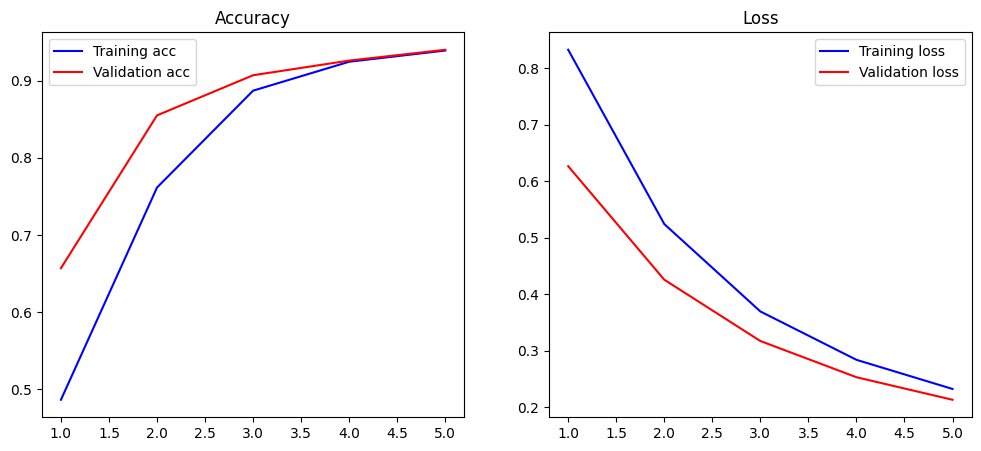

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.title("Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


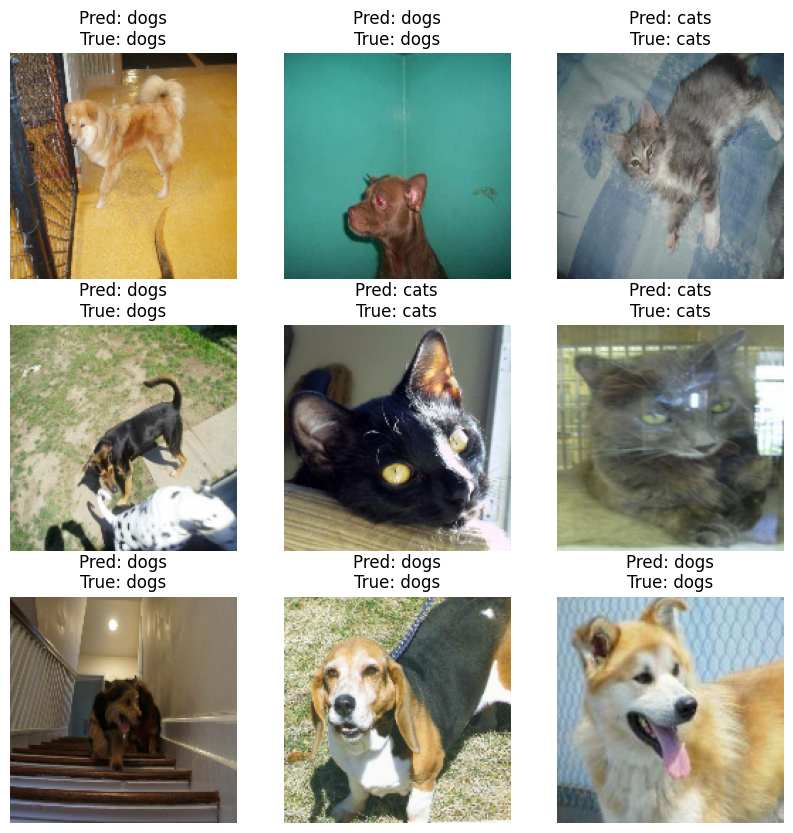

In [10]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = (preds > 0.5).astype("int32")
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[pred_labels[i][0]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")